<a href="https://colab.research.google.com/github/chingya211/Gen-AI/blob/main/61308007E_%E5%B8%AB%E5%A4%A7%E8%B3%87%E6%95%99%E6%89%80%E7%A2%A9%E4%B8%80_%E5%8A%89%E7%80%9E%E9%9B%85_Stable_Diffusion%E7%9A%84WebUI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📚 打造 Stable Diffusion 的 WebUI

### 1. 安裝必要套件

In [ ]:
!pip install diffusers transformers accelerate safetensors huggingface_hub gradio --upgrade

In [ ]:
#from google.colab import userdata

#hf_token = userdata.get("HuggingFace")
#login(token=hf_token)

In [ ]:
from diffusers import StableDiffusionPipeline, UniPCMultistepScheduler
import torch
import gc

import matplotlib.pyplot as plt
import gradio as gr
import random

### 2. 指定並讀入模型

In [ ]:
model_id = "nitrosocke/mo-di-diffusion"

注意有可能要停用 `use_safetensors=True`。

In [ ]:
pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    #use_safetensors=True
).to("cuda")

In [ ]:
from diffusers import DPMSolverMultistepScheduler

pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

### 3. 生成的函式

In [ ]:
def generate_images(prompt, use_enhance, enhance_text, use_negative, negative_text,
                    use_custom_seed, custom_seed, height, width, steps, num_images):

    height = int(height)
    width = int(width)

    if height % 8 != 0 or width % 8 != 0:
        raise ValueError("高度和寬度必須是8的倍數！")

    if use_custom_seed:
        base_seed = int(custom_seed)
    else:
        base_seed = random.randint(0, 2**32 - 1)

    seeds = [base_seed + i for i in range(num_images)]

    prompts = []
    negative_prompts = []
    generators = []

    final_prompt = prompt
    if use_enhance and enhance_text:
        final_prompt = prompt + ", " + enhance_text

    final_negative = negative_text if use_negative else None

    for seed in seeds:
        g = torch.Generator("cuda").manual_seed(seed)
        generators.append(g)
        prompts.append(final_prompt)
        negative_prompts.append(final_negative)

    gc.collect()
    torch.cuda.empty_cache()

    images = []
    for i in range(num_images):
        with torch.no_grad():
            image = pipe(
                prompt=prompts[i],
                negative_prompt=negative_prompts[i] if final_negative else None,
                height=height,
                width=width,
                num_inference_steps=steps,
                guidance_scale=7.5,
                generator=generators[i]
            ).images[0]
            images.append(image)

    return images, f"使用的 random seeds: {seeds}"

### 4. 打造 Gradio Web App

In [ ]:
default_enhance = "3D render, cute pose, Sparkling eyes, big eyes, Sleek body, round eyes, Expressive eyes, soft color palette, simple background."
default_negative = "human, person, bad anatomy, blurry, disfigured, poorly drawn hands, extra fingers, extra limbs, low quality, worst quality, logo, nude, explicit, NSFW"

with gr.Blocks(css=".gradio-container {background-color: #FAFAFA; padding: 20px;} .gr-button {font-size: 18px; background: linear-gradient(to right, #667eea, #764ba2); color: white;}") as demo:
    gr.Markdown("""
    # 🎠 Mo Di Diffusion 美好的事物都在這裡發生
    快來打造你的迪士尼動物寶寶！🐰🥕

    使用 **modern disney style** 施展魔法
    """)

    with gr.Row():
        with gr.Column(scale=6):
            prompt = gr.Textbox(label="Prompt", placeholder="請輸入你的提示詞 (prompt)", lines=3)
            with gr.Row():
                use_enhance = gr.Checkbox(label="加強 Prompt", value=True)
                enhance_text = gr.Textbox(label="加強內容", value=default_enhance)
            with gr.Row():
                use_negative = gr.Checkbox(label="使用 Negative Prompt", value=True)
                negative_text = gr.Textbox(label="Negative Prompt 內容", value=default_negative)
            with gr.Row():
                use_custom_seed = gr.Checkbox(label="自訂 Random Seed", value=False)
                custom_seed = gr.Number(label="指定 seed (選填)", value=42)
            with gr.Row():
                height = gr.Dropdown(["512", "768", "1024"], label="高度 Height", value="512")
                width = gr.Dropdown(["512", "768", "1024"], label="寬度 Width", value="512")
            with gr.Row():
                steps = gr.Slider(10, 50, value=20, step=5, label="生成步數 (Steps)")
                num_images = gr.Slider(1, 4, step=1, value=1, label="生成張數")
            generate_btn = gr.Button("🚀 開始生成！")

        with gr.Column(scale=6):
            gallery = gr.Gallery(label="生成結果", columns=2, object_fit="contain", height="auto")
            seed_info = gr.Label(label="使用的 Random Seeds")

    generate_btn.click(
        fn=generate_images,
        inputs=[prompt, use_enhance, enhance_text, use_negative, negative_text,
                use_custom_seed, custom_seed, height, width, steps, num_images],
        outputs=[gallery, seed_info]
    )

In [ ]:
demo.launch(share=True, debug=True)

 # **📌 主題：Disney風格的動物影像生成**

## 1. 增強Disney morden style的效果：


*   Enhance prompt：
    1. 臉部細節：sparkling eyes, big eyes, sleek body, round eyes, cute pose.
    2. 背景、畫面精細度：soft color palette, simple background, soft lighting, cinematic lighting, smooth shading, 3D render, highly detailed.
*   Negative prompt：

    1. 人物四肢完整度：bad anatomy, blurry, disfigured, poorly drawn hands, extra fingers, mutated hands, cloned, multiple views, duplicate, extra limbs

    2. 圖片品質、敏感內容：low quality, worst quality,realistic, logo, nude, explicit, NSFW

    3. 避免人像：human, person, man, woman, boy, girl, child, adult, face, head, portrait, figure, deformed

    4. 避免裁切：out of frame, cropped, out of frame


## 2. 增加眼睛細節、微笑更符合modern disney style
增加Enhance prompt：Expressive eyes, smile

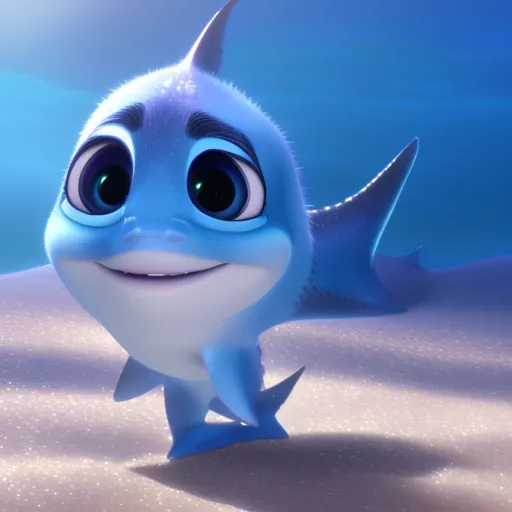

但仍有人物的出現

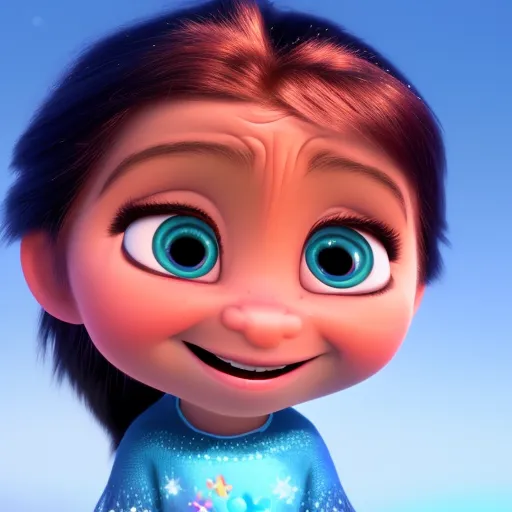

##3. 減少人像圖片產生
將human, person, man, woman, boy, girl, child, adult, face, head, portrait, figure, deformed放到前面強調，明顯降低人像的發生率

* prompt：modern disney style tigger
*   786 x 512
*   生成部署：50
*   生成張數：4

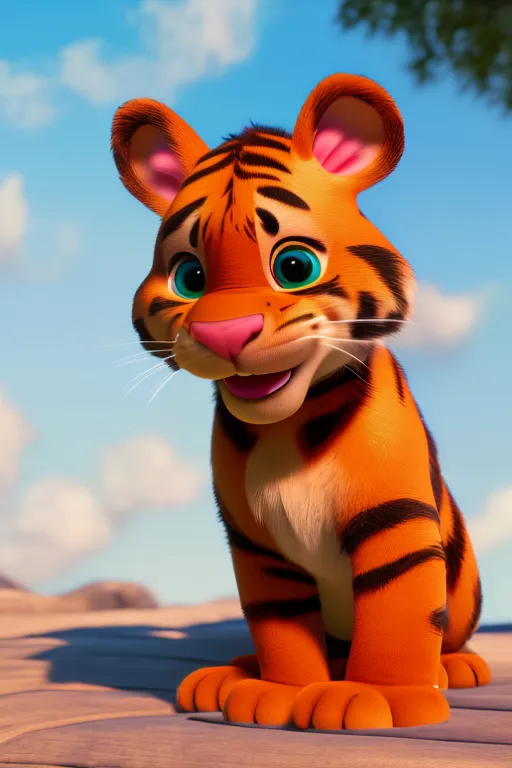

